In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



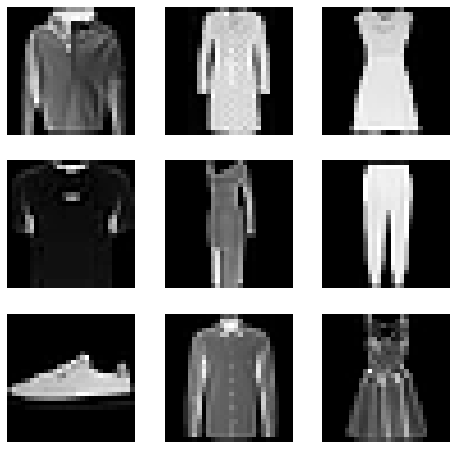

In [2]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size = (1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
print(training_data[3][0].shape)
print(training_data[3][1])

torch.Size([1, 28, 28])
3


In [4]:
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = [[73, 80, 75], [93,88,93], [89,91,90], [96,98,100],[73,66,70]]
    self.y_data  [[152],[185],[180],[196],[142]]

    def __len__(self):
      return len(self.x_data)

    def __getitem__(self, idx):
      x = torch.FloatTensor(self.x_data[idx])
      y = torch.FloatTensor(self.y_data[idx])
      return x,y

In [5]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y:torch.zeros(10, dtype=torch.float).scatter_(0,
    torch.tensor(y), value=1))    
)
print(ds[0][0].shape)
print(ds[0][1])

torch.Size([1, 28, 28])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=512, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=512, shuffle=False)


Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


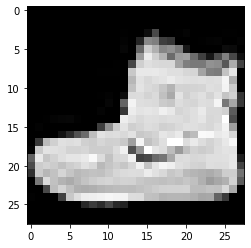

Label: 9


In [7]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: { label}")

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [13]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
lr = 0.001
epochs=40
model_list = [MLP().to(device) for i in range(6)]
criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer_list = [torch.optim.SGD(model_list[0].parameters(),lr=lr),torch.optim.SGD(model_list[1].parameters(), lr=lr, momentum=0.9),
                  torch.optim.SGD(model_list[2].parameters(),lr=lr,momentum=0.9,nesterov=True),torch.optim.Adagrad(model_list[4].parameters(), lr=lr),
                  torch.optim.RMSprop(model_list[4].parameters(),lr=lr),torch.optim.Adam(model_list[5].parameters(), lr=lr)]                    


In [ ]:
train_loss_list= [[]for i in range(6)]
test_loss_list=[[]for i in range(6)]
for model_idx, optimizer in enumerate(optimizer_list):
  model = model_list[model_idx]
  train_loss_l = train_loss_list[model_idx]
  test_loss_l = test_loss_list[model_idx]
  for epoch in range(epochs):
    train_loss, train_correct = 0, 0
    for batch_idx, (X_train,y_train) in enumerate(train_dataloader):
      model.train()
      optimizer.zero_grad()
      X_train = X_train.to(device)
      y_train = y_train.to(device)
      pred = model(X_train)
      loss = criterion(pred,y_train)
      train_loss += (pred.argmax(1) == y_train).type(torch.float).sum().item()
      loss.backward()
      optimizer.step()
      if batch_idx % 100 == 0:
        loss, current = loss.item(), batch_idx * len(X_train)
      train_loss /= len(train_dataloader)
      train_loss_l.append(train_loss)
      train_correct /=len(train_dataloader.dataset)
      print(f"Train Error: \n Accuracy: {(100*train_correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
      test_loss, test_correct = 0,0
      model.eval()
      with torch.no_grad():
        for X_test, y_test in test_dataloader:
          X_test = X_test.to(device)
          y_test = y_test.to(device)
          pred = model(X_test)
          test_loss += criterion(pred, y_test).item()
          test_correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()
        test_loss /= len(test_dataloader)
        test_loss_l.append(test_loss)
        test_correct /= len(test_dataloader.dataset)
        print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avgloss: {test_loss:>8f} \n")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 Accuracy: 0.0%, Avg loss: 3.590319 

Test Error: 
 Accuracy: 82.6%, Avgloss: 0.508294 

Train Error: 
 Accuracy: 0.0%, Avg loss: 3.852460 

Test Error: 
 Accuracy: 82.6%, Avgloss: 0.508388 

Train Error: 
 Accuracy: 0.0%, Avg loss: 3.685190 

Test Error: 
 Accuracy: 82.6%, Avgloss: 0.508105 

Train Error: 
 Accuracy: 0.0%, Avg loss: 3.658349 

Test Error: 
 Accuracy: 82.6%, Avgloss: 0.508002 

Train Error: 
 Accuracy: 0.0%, Avg loss: 3.683545 

Test Error: 
 Accuracy: 82.6%, Avgloss: 0.508131 

Train Error: 
 Accuracy: 0.0%, Avg loss: 3.624437 

Test Error: 
 Accuracy: 82.6%, Avgloss: 0.508152 

Train Error: 
 Accuracy: 0.0%, Avg loss: 3.530716 

Test Error: 
 Accuracy: 82.5%, Avgloss: 0.508189 

Train Error: 
 Accuracy: 0.0%, Avg loss: 3.699413 

Test Error: 
 Accuracy: 82.6%, Avgloss: 0.508278 

Train Error: 
 Accuracy: 0.0%, Avg loss: 3.607622 

Test Error: 
 Accuracy: 82.6%, Avgloss: 0.508258 

Train Error: 
 Accuracy: 0.0%, Avg loss: 3.717014 


In [ ]:
label_list = ["SGD", "SGD+M","SGD+m+n","Adagrad","RMSprop:,:Adam:"]
epoch_list = [i+1 for i in range(40)]
for i, label in enumerate(label_list):
  plt.plot(epoch_list, train_loss_list[i],label=label)
plt.legend(loc='upper right')
plt.xlabel('iteration')
plt.ylabel('loss')